## Binning demonstration on locally generated fake data
In this example, we generate a table with random data simulating a single event dataset.
We showcase the binning method, first on a simple single table using the bin_partition method and then in the distributed mehthod bin_dataframe, using daks dataframes.
The first method is never really called directly, as it is simply the function called by the bin_dataframe on each partition of the dask dataframe.

In [1]:
import sys

import dask
import numpy as np
import pandas as pd
import dask.dataframe

import matplotlib.pyplot as plt

sys.path.append("../")
from sed.binning import bin_partition, bin_dataframe

### Generate Fake Data

In [2]:
n_pts = 100000
cols = ["posx", "posy", "energy"]
df = pd.DataFrame(np.random.randn(n_pts, len(cols)), columns=cols)
df

,posx,posy,energy
0,-2.172222,0.042063,0.867499
1,0.202604,0.039688,-0.133870
2,0.075493,0.259146,0.426713
3,-0.695079,1.520737,1.265631
4,-0.859571,-0.310253,-0.244222
...,...,...,...
99995,-0.508565,-0.337230,-0.899860
99996,-0.550641,-0.433369,-0.232197
99997,0.222835,-1.307487,-0.505768
99998,-0.755962,0.105664,0.619708


### Define the binning range

In [3]:
binAxes = ["posx", "posy", "energy"]
nBins = [120, 120, 120]
binRanges = [(-2, 2), (-2, 2), (-2, 2)]
coords = {ax: np.linspace(r[0], r[1], n) for ax, r, n in zip(binAxes, binRanges, nBins)}

### Compute the binning along the pandas dataframe

In [4]:
%%time
res = bin_partition(
    part=df,
    bins=nBins,
    axes=binAxes,
    ranges=binRanges,
    hist_mode="numba",
)

CPU times: user 1.36 s, sys: 40.3 ms, total: 1.4 s
Wall time: 1.4 s


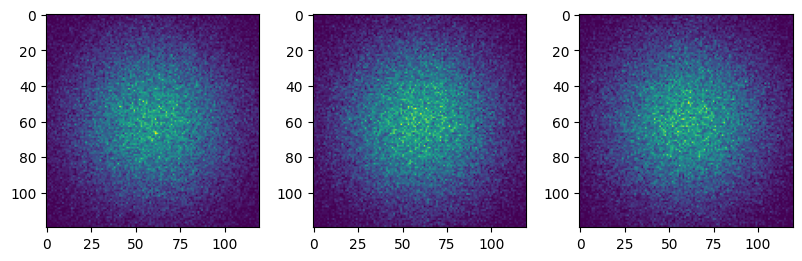

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(8, 2.5), constrained_layout=True)
for i in range(3):
    axs[i].imshow(res.sum(i))

### Transform to dask dataframe

In [6]:
ddf = dask.dataframe.from_pandas(df, npartitions=50)
ddf

,posx,posy,energy
npartitions=50,,,
0,float64,float64,float64
2000,...,...,...
...,...,...,...
98000,...,...,...
99999,...,...,...


### Compute distributed binning on the partitioned dask dataframe
In this example, the small dataset does not give significant improvement over the pandas implementation, at least using this number of partitions.
A single partition would be faster (you can try...) but we use multiple for demonstration purpouses.

In [7]:
%%time
res = bin_dataframe(
    df=ddf,
    bins=nBins,
    axes=binAxes,
    ranges=binRanges,
    hist_mode="numba",
)

  0%|          | 0/17 [00:00<?, ?it/s]

CPU times: user 885 ms, sys: 354 ms, total: 1.24 s
Wall time: 798 ms


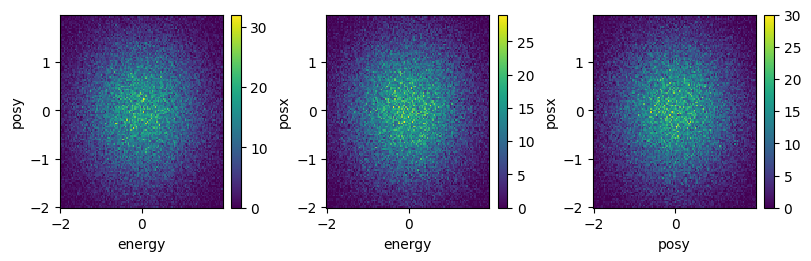

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(8, 2.5), constrained_layout=True)
for dim, ax in zip(binAxes, axs):
    res.sum(dim).plot(ax=ax)